In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import init
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL
from PIL import Image

to_pil = torchvision.transforms.ToPILImage()
n = 20

In [183]:
def load_data(n):
    X = []
    for i in range(n):
        try:
            img = Image.open(f"../images/screenshot_{i}.png")
        except:
            continue
        np_img = np.array(img)/255
        np_img = np.rollaxis(np_img, 2, 0)
        X.append(np_img)
    Y = np.load('../images/image_labels.npy')
    X = np.array(X)
    return X,Y

In [184]:
X,Y = load_data(n)
split = int(n-0.25*n)
Xt,Yt = X[:split,:,:,:],Y[:split,:,:]
Xv,Yv = X[split:,:,:,:],Y[split:,:,:]
Xt,Yt,Xv,Yv = torch.Tensor(Xt),torch.Tensor(Yt),torch.Tensor(Xv),torch.Tensor(Yv)

In [185]:
X.shape
Y.shape
print(Xv.shape)
print(Yv.shape)

torch.Size([5, 3, 400, 800])
torch.Size([5, 400, 800])


In [186]:
dataset = torch.utils.data.TensorDataset(Xt, Yt)
dataset_val = torch.utils.data.TensorDataset(Xv, Yv)

torch.Size([3, 400, 800])
torch.Size([400, 800])


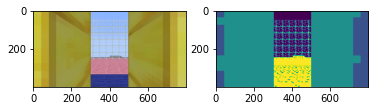

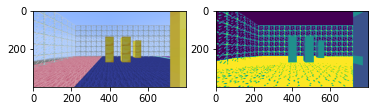

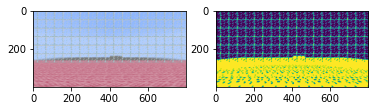

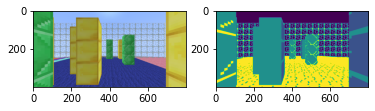

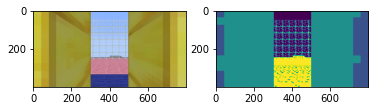

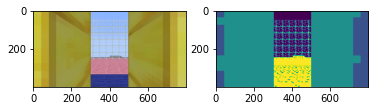

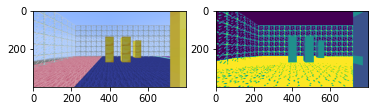

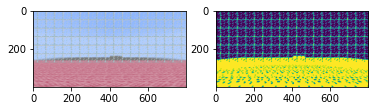

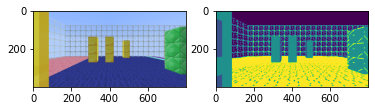

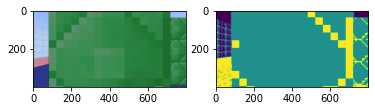

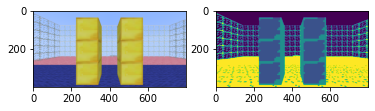

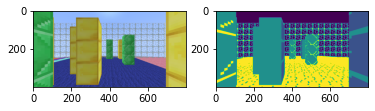

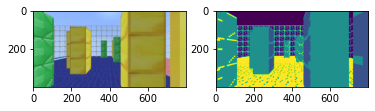

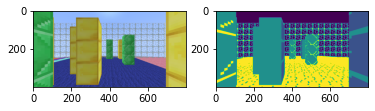

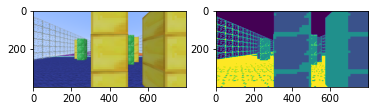

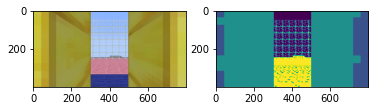

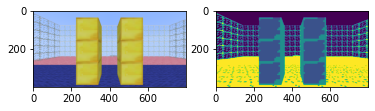

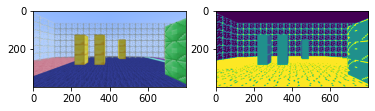

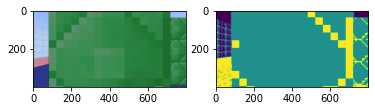

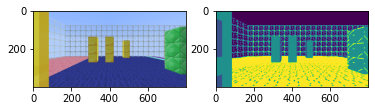

In [187]:
idx = np.random.choice(len(dataset), n)
print(dataset[0][0].shape)
print(dataset[0][1].shape)
for i,j in enumerate(idx):
    _, axarr = plt.subplots(1, 2)
    img,label = dataset[j]
    temp = to_pil(img)
    axarr[0].imshow(temp)
    axarr[1].imshow(label, cmap='viridis',vmin=0, vmax=4)
    plt.show()